In [1]:
import pandas as pd
from pickleshare import PickleShareDB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, balanced_accuracy_score, matthews_corrcoef, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

## Chargement des données

In [2]:
db = PickleShareDB('../prep_data/kity')
sample_df = db['net_sample_for_models']

Le type 'scan' d'attaque a tres peu d'entrees, ce qui empeche les modeles. On supprime ce type d'attaque.

In [3]:
to_drop = sample_df[sample_df['label'] == 'scan'].index
sample_df = sample_df.drop(to_drop)

In [4]:
labels = sample_df[['label', 'label_n']]
sample_df.drop(columns=['label', 'label_n'], inplace=True)

## Initialisation du modèle

In [12]:
X = sample_df
y_label_n = labels['label_n']
y_label = labels['label']

y_label_n_str = y_label_n.astype(str)
# Encoder les labels en int
le = LabelEncoder()
y_label_n_encoded = le.fit_transform(y_label_n)

ordered_classes = ['normal', 'DoS','physical fault', 'MITM', 'anomaly']
label_map = {label: idx for idx, label in enumerate(ordered_classes)}
y_label_encoded = [label_map[label] for label in y_label]

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y_label_n_str, test_size=0.2, random_state=42, stratify=y_label_n_str)


In [13]:
# Initialiser le modèle CART 
cart = DecisionTreeClassifier(
    criterion='gini',
    max_depth=None,
    random_state=42
)

cart.fit(X_train, y_train)

# Prédire les étiquettes sur l'ensemble de test
y_pred = cart.predict(X_test)

## Évaluation

In [14]:
def tpr_tnr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity
    return tpr, tnr

### Données équilibrées

In [15]:
# Métriques pour les données équilibrées
precision = precision_score(y_test, y_pred, average='binary', pos_label='True')
recall = recall_score(y_test, y_pred, average='binary', pos_label='True')
accuracy = accuracy_score(y_test, y_pred)
tpr, tnr = tpr_tnr(y_test, y_pred)

print(f"Précision : {precision:.2f}")
print(f"Rappel : {recall:.2f}")
print(f"TPR (Sensibilité) : {tpr:.2f}")
print(f"TNR (Spécificité) : {tnr:.2f}")
print(f"Exactitude (Accuracy) : {accuracy:.2f}")

Précision : 0.98
Rappel : 0.58
TPR (Sensibilité) : 0.58
TNR (Spécificité) : 0.99
Exactitude (Accuracy) : 0.82


### Données déséquilibrées 

In [9]:
# Métriques pour les données déséquilibrées
f1 = f1_score(y_test, y_pred, average='binary', pos_label='True')
balanced_acc = balanced_accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

print(f"F1-Score : {f1:.2f}")
print(f"Précision équilibrée : {balanced_acc:.2f}")
print(f"Coefficient de Matthews : {mcc:.2f}")

F1-Score : 0.73
Précision équilibrée : 0.79
Coefficient de Matthews : 0.65


### Matrice de confusion 

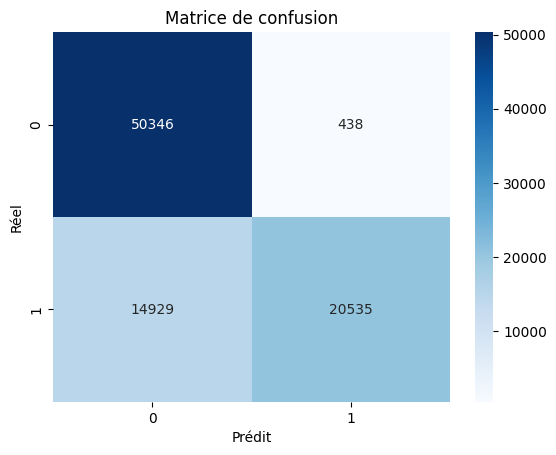

In [10]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.show()

### Visualisation de l'arbre de décision

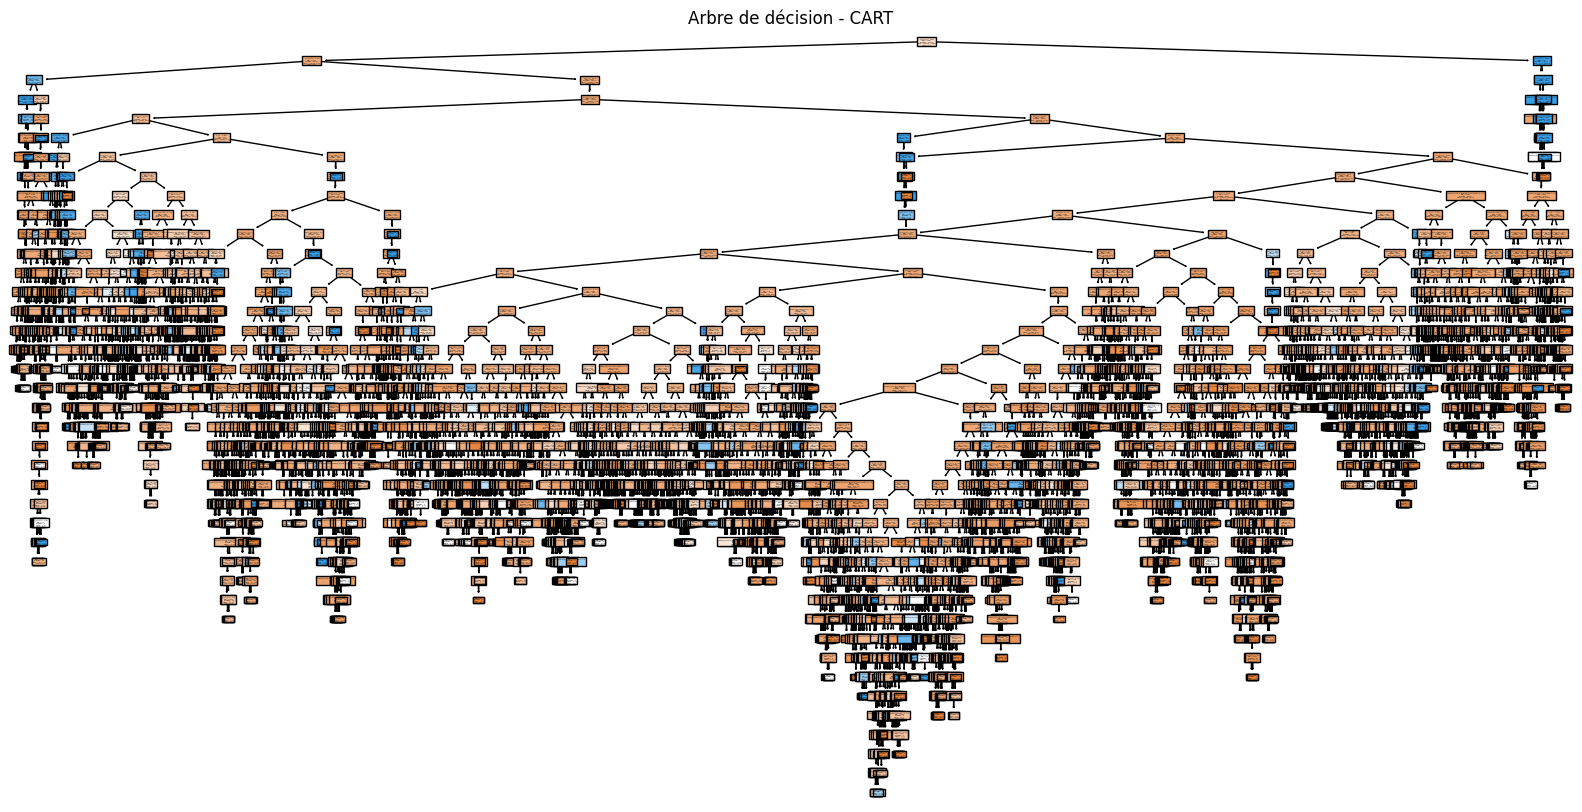

In [11]:
plt.figure(figsize=(20, 10))
plot_tree(cart, feature_names=X.columns, class_names=cart.classes_, filled=True)
plt.title("Arbre de décision - CART")
plt.show()